In [1]:
import json
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModel, AutoTokenizer, get_scheduler
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from tqdm.notebook import tqdm, trange
from time import perf_counter
from PIL import Image
import pandas as pd

import numpy as np
import random

In [2]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# set random seeds for repeatability

def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

seed_val = 0
set_seed(seed_val)

In [4]:
# HOME_FOLDER = '/content/drive/MyDrive/KDD/' # if mounted
HOME_FOLDER = 'KDD/' # if not mounted
DATA_FOLDER = HOME_FOLDER + 'dataset/'
IMAGE_FOLDER = DATA_FOLDER + 'images/'
RESULTS_FOLDER = HOME_FOLDER + 'results/'
TRAINED_MODELS_FOLDER = HOME_FOLDER + 'trained_models/'
os.makedirs(RESULTS_FOLDER, exist_ok=True)

In [5]:
df_train = pd.read_csv(DATA_FOLDER + 'train_image_data.csv')
df_val = pd.read_csv(DATA_FOLDER + 'val_image_data.csv')
df_test = pd.read_csv(DATA_FOLDER + 'test_image_data.csv')


Index: 6311
Label: Blue
Text: tupperware


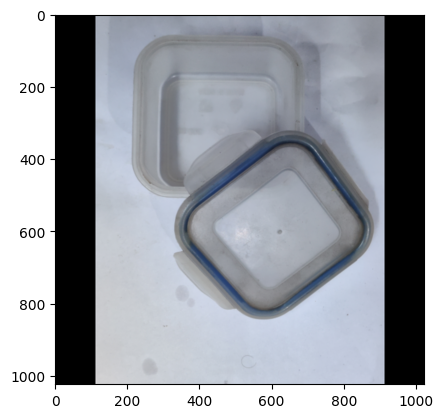

In [6]:
import matplotlib.pyplot as plt

def show_sample(row_num):
    sample_row = df_train.iloc[row_num]
    print('Index:', row_num)
    print('Label:', sample_row['label'])
    print('Text:', sample_row['text'])
    image_path = IMAGE_FOLDER + sample_row['img_path']
    im = Image.open(image_path)
    plt.imshow(im)

from random import randint
show_sample(randint(0, len(df_train)))

In [7]:
label_to_id = {lab:i for i, lab in enumerate(df_train['label'].sort_values().unique())}
id_to_label = {v:k for k,v in label_to_id.items()}

In [8]:
label_to_id

{'Black': 0, 'Blue': 1, 'Green': 2, 'TTR': 3}

In [9]:
num_out_labels = len(label_to_id)

In [10]:
## training parameters to be used for all models ##
num_train_epochs = 30
batch_size = 128
learning_rate = 1.0e-5
weight_decay = 0.1
warmup_steps = 0
max_seq_length = 64

In [11]:
# class ResNetDataset(Dataset):
#     def __init__(self, df, label_to_id, train=False, text_field="text", label_field="label", image_path_field="img_path"):
#         self.df = df.reset_index(drop=True)
#         self.label_to_id = label_to_id
#         self.train = train
#         self.text_field = text_field
#         self.label_field = label_field
#         self.image_path_field = image_path_field

#         # ResNet-50 settings
#         self.img_size = 224
#         self.mean, self.std = (
#             0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)


#         self.train_transform_func = transforms.Compose(
#                 [transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
#                     transforms.RandomHorizontalFlip(),
#                     transforms.ToTensor(),
#                     transforms.Normalize(self.mean, self.std)
#                     ])

#         self.eval_transform_func = transforms.Compose(
#                 [transforms.Resize(256),
#                     transforms.CenterCrop(self.img_size),
#                     transforms.ToTensor(),
#                     transforms.Normalize(self.mean, self.std)
#                     ])


#     def __getitem__(self, index):
#         text = str(self.df.at[index, self.text_field])
#         label = self.label_to_id[self.df.at[index, self.label_field]]
#         img_path = IMAGE_FOLDER + self.df.at[index, self.image_path_field]


#         image = Image.open(img_path)
#         if self.train:
#           img = self.train_transform_func(image)
#         else:
#           img = self.eval_transform_func(image)

#         return text, label, img

#     def __len__(self):
#         return self.df.shape[0]

In [12]:
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class ResNetDataset(Dataset):
    def __init__(self, df, label_to_id, train=False, text_field="text", label_field="label", image_path_field="img_path"):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.train = train
        self.text_field = text_field
        self.label_field = label_field
        self.image_path_field = image_path_field

        # ResNet-50 settings
        self.img_size = 224
        self.mean, self.std = (
            0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)

        self.train_transform_func = transforms.Compose(
            [
                transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(self.mean, self.std)
            ]
        )

        self.eval_transform_func = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(self.img_size),
                transforms.ToTensor(),
                transforms.Normalize(self.mean, self.std)
            ]
        )

    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]
        img_path = IMAGE_FOLDER + self.df.at[index, self.image_path_field]

        # Open image and convert to RGB
        image = Image.open(img_path).convert("RGB")  # Convert to RGB to avoid issues with alpha channel

        if self.train:
            img = self.train_transform_func(image)
        else:
            img = self.eval_transform_func(image)

        return text, label, img

    def __len__(self):
        return self.df.shape[0]


In [13]:
# extract layers of resnet-50 to build a new model

import torch.nn as nn
from torchvision.models.resnet import resnet50

class ResNetFeatureModel(nn.Module):
    def __init__(self, output_layer):
        super().__init__()
        self.output_layer = output_layer
        pretrained_resnet = resnet50(pretrained=True)
        self.children_list = []
        for n,c in pretrained_resnet.named_children():
            self.children_list.append(c)
            if n == self.output_layer:
                break

        self.net = nn.Sequential(*self.children_list)


    def forward(self,x):
        x = self.net(x)
        x = torch.flatten(x, 1)
        return x

In [14]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [15]:
# last output layer name for resnet is named 'layer4', dim 2048*7*7
# last layer name before fc is named 'avgpool', dim 2048*1*1 -> needs to be flattened
# reference: https://medium.com/the-owl/extracting-features-from-an-intermediate-layer-of-a-pretrained-model-in-pytorch-c00589bda32b

class BertResNetModel(nn.Module):
    def __init__(self, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_pretrained)
        self.visual_encoder = ResNetFeatureModel(output_layer='avgpool')
        self.image_hidden_size = 2048
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with 50% dropout rate
        self.classifier = nn.Linear(self.text_encoder.config.hidden_size + self.image_hidden_size, num_labels)

    def forward(self, text, image):
        text_output = self.text_encoder(**text)
        text_feature = text_output.last_hidden_state[:, 0, :]
        #img_feature = self.visual_encoder(image)
        img_feature = self.visual_encoder(image).view(image.size(0), -1)  # Flatten image features
        features = torch.cat((text_feature, img_feature), 1)
        features = self.dropout(features)  # Apply dropout
        logits = self.classifier(features)

        return logits

In [16]:
resnet_model = BertResNetModel(num_labels=num_out_labels, text_pretrained='bert-base-uncased')
resnet_model = resnet_model.to(device)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:

## training loop
set_seed(seed_val)

train_dataset = ResNetDataset(df=df_train, label_to_id=label_to_id, train=True, text_field='text', label_field='label', image_path_field='img_path')
train_sampler = RandomSampler(train_dataset)        
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size, 
                    sampler=train_sampler)


t_total = len(train_dataloader) * num_train_epochs


optimizer = AdamW(resnet_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()




# Define validation dataset and dataloader
val_dataset = ResNetDataset(df=df_val, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path')
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Initialize a variable to track the best validation loss
best_val_loss = float("inf")

#early stop
patience = 5
patience_counter = 0





start = perf_counter()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    resnet_model.train()
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):        
        b_text, b_labels, b_imgs = batch            
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )
        
        b_labels = b_labels.to(device)
        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)

        resnet_model.zero_grad()        
        b_logits = resnet_model(text=b_inputs, image=b_imgs)
        
        loss = criterion(b_logits, b_labels)

        epoch_total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()


        optimizer.step()
        scheduler.step()
        
    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])




    # Validation Phase
    resnet_model.eval()
    val_loss = 0
    
    correct_predictions = 0  # Track correct predictions
    total_samples = 0  # Track total number of samples
    
    with torch.no_grad():
        for batch in val_dataloader:
            b_text, b_labels, b_imgs = batch
            b_inputs = bert_tokenizer(
                list(b_text), truncation=True, max_length=max_seq_length,
                return_tensors="pt", padding=True
            )
            
            b_labels = b_labels.to(device)
            b_imgs = b_imgs.to(device)
            b_inputs = b_inputs.to(device)

            b_logits = resnet_model(text=b_inputs, image=b_imgs)
            val_loss += criterion(b_logits, b_labels).item()
            
            
            #calculate accuracy
            _, preds = torch.max(b_logits, dim=1)  # Get predicted class
            correct_predictions += (preds == b_labels).sum().item()
            total_samples += b_labels.size(0)
            
            
            
    val_accuracy = correct_predictions / total_samples
    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch {epoch_num}: Validation Loss = {avg_val_loss:.4f}')
    print(f'Epoch {epoch_num}: Validation Accuracy = {val_accuracy:.4f}')
    
    

    # Check if this is the best model so far based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0 #reset counter
        torch.save(resnet_model.state_dict(), "best_model.pt")
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

    else:
        patience_counter += 1
        print(f'No improvement, patience counter: {patience_counter}/{patience}')
    
    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered at epoch {epoch_num}')
        break




end = perf_counter()
resnet_training_time = end- start
print('Training completed in ', resnet_training_time, 'seconds')

Batch: 100%|██████████| 80/80 [29:53<00:00, 22.42s/it]


epoch = 0
    epoch_loss = 63.90882846713066
    avg_epoch_loss = 0.7988603558391333
    learning rate = 9.972609476841368e-06
Epoch 0: Validation Loss = 0.4542
Epoch 0: Validation Accuracy = 0.8428


Epochs:   3%|▎         | 1/30 [33:00<15:57:01, 1980.06s/it]

Best model saved with validation loss: 0.4542


Batch: 100%|██████████| 80/80 [29:57<00:00, 22.47s/it]


epoch = 1
    epoch_loss = 30.423726350069046
    avg_epoch_loss = 0.3802965793758631
    learning rate = 9.890738003669029e-06
Epoch 1: Validation Loss = 0.3602
Epoch 1: Validation Accuracy = 0.8800


Epochs:   7%|▋         | 2/30 [1:06:03<15:24:55, 1981.98s/it]

Best model saved with validation loss: 0.3602


Batch: 100%|██████████| 80/80 [29:16<00:00, 21.96s/it]


epoch = 2
    epoch_loss = 22.6644070148468
    avg_epoch_loss = 0.28330508768558504
    learning rate = 9.755282581475769e-06
Epoch 2: Validation Loss = 0.3226
Epoch 2: Validation Accuracy = 0.8867


Epochs:  10%|█         | 3/30 [1:38:25<14:43:43, 1963.82s/it]

Best model saved with validation loss: 0.3226


Batch: 100%|██████████| 80/80 [29:19<00:00, 21.99s/it]


epoch = 3
    epoch_loss = 18.93222876638174
    avg_epoch_loss = 0.23665285957977175
    learning rate = 9.567727288213005e-06
Epoch 3: Validation Loss = 0.3168
Epoch 3: Validation Accuracy = 0.8933


Epochs:  13%|█▎        | 4/30 [2:10:50<14:07:42, 1956.23s/it]

Best model saved with validation loss: 0.3168


Batch: 100%|██████████| 80/80 [29:18<00:00, 21.98s/it]


epoch = 4
    epoch_loss = 15.812804371118546
    avg_epoch_loss = 0.1976600546389818
    learning rate = 9.330127018922195e-06
Epoch 4: Validation Loss = 0.3101
Epoch 4: Validation Accuracy = 0.9044


Epochs:  17%|█▋        | 5/30 [2:43:14<13:33:14, 1951.79s/it]

Best model saved with validation loss: 0.3101


Batch: 100%|██████████| 80/80 [29:14<00:00, 21.94s/it]


epoch = 5
    epoch_loss = 13.599813230335712
    avg_epoch_loss = 0.16999766537919642
    learning rate = 9.045084971874738e-06


Epochs:  20%|██        | 6/30 [3:15:34<12:59:06, 1947.75s/it]

Epoch 5: Validation Loss = 0.3171
Epoch 5: Validation Accuracy = 0.9028
No improvement, patience counter: 1/5


Batch: 100%|██████████| 80/80 [29:10<00:00, 21.88s/it]


epoch = 6
    epoch_loss = 11.109669022262096
    avg_epoch_loss = 0.1388708627782762
    learning rate = 8.715724127386971e-06


Epochs:  23%|██▎       | 7/30 [3:47:48<12:25:00, 1943.49s/it]

Epoch 6: Validation Loss = 0.3149
Epoch 6: Validation Accuracy = 0.9133
No improvement, patience counter: 2/5


Batch: 100%|██████████| 80/80 [29:11<00:00, 21.89s/it]


epoch = 7
    epoch_loss = 9.4232447296381
    avg_epoch_loss = 0.11779055912047624
    learning rate = 8.345653031794292e-06


Epochs:  27%|██▋       | 8/30 [4:20:04<11:51:45, 1941.18s/it]

Epoch 7: Validation Loss = 0.3239
Epoch 7: Validation Accuracy = 0.9089
No improvement, patience counter: 3/5


Batch: 100%|██████████| 80/80 [29:22<00:00, 22.03s/it]


epoch = 8
    epoch_loss = 8.391624204814434
    avg_epoch_loss = 0.10489530256018043
    learning rate = 7.938926261462366e-06


Epochs:  30%|███       | 9/30 [4:52:32<11:20:07, 1943.22s/it]

Epoch 8: Validation Loss = 0.3200
Epoch 8: Validation Accuracy = 0.9072
No improvement, patience counter: 4/5


Batch: 100%|██████████| 80/80 [29:13<00:00, 21.92s/it]


epoch = 9
    epoch_loss = 6.93097903393209
    avg_epoch_loss = 0.08663723792415112
    learning rate = 7.500000000000001e-06


Epochs:  30%|███       | 9/30 [5:24:51<12:38:00, 2165.72s/it]

Epoch 9: Validation Loss = 0.3252
Epoch 9: Validation Accuracy = 0.9033
No improvement, patience counter: 5/5
Early stopping triggered at epoch 9
Training completed in  19491.447786165998 seconds


In [20]:
# testing loop

resnet_model.load_state_dict(torch.load("best_model.pt", map_location=device))


resnet_prediction_results = []

test_dataset = ResNetDataset(df=df_test, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path')
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            sampler=test_sampler)


for batch in tqdm(test_dataloader):
  resnet_model.eval()

  b_text, b_labels, b_imgs = batch

  b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

  b_labels = b_labels.to(device)
  b_imgs = b_imgs.to(device)
  b_inputs = b_inputs.to(device)

  with torch.no_grad():
      b_logits = resnet_model(text=b_inputs, image=b_imgs)
      b_logits = b_logits.detach().cpu()

  resnet_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

resnet_prediction_labels = [id_to_label[p] for p in resnet_prediction_results]

/var/folders/9w/bvj8jnnd4979ylmj01tbvy8w0000gn/T/ipykernel_1633/570214165.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load("best_m

In [21]:
resnet_class_report = classification_report(df_test['label'], resnet_prediction_labels, output_dict=True)
#resnet_class_report['training_time (seconds)'] = resnet_training_time

with open(RESULTS_FOLDER + 'resnet_class_report.json', 'w') as f:
  json.dump(resnet_class_report, f)

print(resnet_class_report['accuracy'])

0.8423200233168172


In [22]:
# Load tokenizer and define device
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reinitialize model architecture and load weights
num_labels = 4  # Adjust based on your task
model = BertResNetModel(num_labels=num_labels).to(device)
model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()  # Set to evaluation mode

# Define image transformations
img_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

# Prediction function
def predict(text, img_path):
    # Tokenize and process the text input
    inputs = bert_tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    
    # Load and preprocess the image
    image = Image.open(img_path).convert("RGB")
    image = img_transforms(image).unsqueeze(0).to(device)  # Add batch dimension
    
    # Perform inference
    with torch.no_grad():
        logits = model(text=inputs, image=image)
        prediction = logits.argmax(dim=1).item()  # Get predicted label
    
    return prediction

# Example usage
sample_text = "expired_rotten_apple_compostable"
sample_img_path = "KDD/dataset/images/expired_rotten_apple_compostable_1187.png"  # Provide the actual path to an image file
predicted_label = predict(sample_text, sample_img_path)
print("Predicted label:", predicted_label)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/9w/bvj8jnnd4979ylmj01tbvy8w0000gn/T/ipykernel_1633/3804289483.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute a

Predicted label: 2


In [23]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm

# Load the test dataset
test_dataset = ResNetDataset(df=df_test, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path')
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Load the best model
resnet_model = BertResNetModel(num_labels=len(label_to_id))
resnet_model.load_state_dict(torch.load("best_model084.pt"))
resnet_model.to(device)
resnet_model.eval()

# Initialize lists to store results
img_paths = []
predictions = []
truths = []

# Run inference on the test dataset
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        b_text, b_labels, b_imgs = batch
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )
        
        b_labels = b_labels.to(device)
        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)

        # Get model predictions
        b_logits = resnet_model(text=b_inputs, image=b_imgs)
        _, preds = torch.max(b_logits, dim=1)
        
        # Store results
        img_paths.extend(test_dataset.df['img_path'][len(img_paths):len(img_paths) + len(preds)].tolist())
        predictions.extend(preds.cpu().tolist())
        truths.extend(b_labels.cpu().tolist())

# Convert label IDs back to label names
id_to_label = {v: k for k, v in label_to_id.items()}
predictions = [id_to_label[p] for p in predictions]
truths = [id_to_label[t] for t in truths]

# Save results to CSV
results_df = pd.DataFrame({
    "img_path": img_paths,
    "prediction": predictions,
    "truth": truths
})
results_df.to_csv("test_results.csv", index=False)
print("Test results saved to test_results.csv")


/var/folders/9w/bvj8jnnd4979ylmj01tbvy8w0000gn/T/ipykernel_1633/227417235.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load("best_

Test results saved to test_results.csv
